In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import random
from PIL import Image
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as F

from class_weights import gen_cls_wts
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# seed everything
seed = 42
# python RNG
import random
random.seed(seed)
# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
import numpy as np
np.random.seed(seed)

# DataLoaders and Model Initialization

In [3]:
def ifnone(a,b):
    if a is None:
        return b
    else:
        return a
def transform(input, target,size=(720,960)):
    a, t, sc, sh = transforms.RandomAffine.get_params(degrees=(0,0),
                                                      translate=(0.1,0.1),
                                                      scale_ranges=(2,2),
                                                      shears=(5,5),
                                                      img_size=size)
    input = F.affine(input, a, t, sc, sh)
    target = F.affine(target, a, t, sc, sh)
    if random.random() > 0.5:
        input = F.hflip(input)
        target = F.hflip(target)
    input,target = F.to_tensor(input), torch.Tensor(np.array(target))
    input = F.normalize(input,imagenet_stats[0],imagenet_stats[1])
    return input, target
def prep_mask(mask):
    return torch.Tensor(mask)
class CamvidDataset(Dataset):
    def __init__(self,path,train=True,label_func=None):
        self.path = path
        all_files = glob.glob(path+'/images/*.png')
        valid_files = []
        with open(path+'/valid.txt','r') as f:
            for line in f:
                valid_files.append(path+'/images/'+line[:-1])
        if train:            
            self.files = [x for x in all_files if x not in valid_files]
        else:
            self.files = valid_files
        self.label_func = ifnone(label_func, lambda x: path+'/labels/'+x.split('/')[-1][:-4]+'_P.png')
        self.label_files = [self.label_func(x) for x in self.files]
        self.c = 32
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        im = Image.open(self.files[i])
        mask = Image.open(self.label_files[i])
        im,mask = transform(im,mask)    
        return {'im':im,'mask':mask}
class CamvidNewDataset(Dataset):
    def __init__(self,path,transforms=True,train=True,label_func=None):
        self.path = path
        self.files = glob.glob(path+'/*.png')
        self.label_func = label_func
        self.label_files = [self.label_func(x) for x in self.files]
        self.transform = transforms
        self.c = 12
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        im = Image.open(self.files[i])
        mask = Image.open(self.label_files[i])
        if self.transform:
            im,mask = transform(im,mask,(360,480))    
        else:
            im,mask = F.to_tensor(im),torch.tensor(np.array(mask))
            im = F.normalize(im,imagenet_stats[0],imagenet_stats[1])
        return {'im':im,'mask':mask.squeeze()}
class CamvidCombDataset(Dataset):
    def __init__(self,path,filelist,transforms=True,label_func=None):
        self.path = path
        all_files = glob.glob(path+'/images/*.png')
        names = []
        with open(filelist,'r') as f:
            for line in f:
                names.append(path+'/images/'+line.split(' ')[0].split('/')[-1])
        self.files = [x for x in all_files if x in names]
        self.label_func = ifnone(label_func, lambda x: path+'/labels/'+x.split('/')[-1][:-4]+'_P.png')
        self.label_files = [self.label_func(x) for x in self.files]
        self.transform = transforms
        self.c = 12
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        im = Image.open(self.files[i])
        mask = Image.open(self.label_files[i])
        if self.transform:
            im,mask = transform(im,mask)    
        else:
            im,mask = F.to_tensor(im),torch.tensor(np.array(mask))
            im = F.normalize(im,imagenet_stats[0],imagenet_stats[1])
        return {'im':im,'mask':mask.squeeze()}

In [4]:
train_data = CamvidNewDataset('../SegNet-Tutorial/CamVid/train',True,
                           label_func=lambda x: '/'.join(x.split('/')[:-2])+'/trainannot/'+x.split('/')[-1])
valid_data = CamvidNewDataset('../SegNet-Tutorial/CamVid/val',False,
                           label_func=lambda x: '/'.join(x.split('/')[:-2])+'/valannot/'+x.split('/')[-1])
test_data = CamvidNewDataset('../SegNet-Tutorial/CamVid/test',False,
                           label_func=lambda x: '/'.join(x.split('/')[:-2])+'/testannot/'+x.split('/')[-1])
train_dl = DataLoader(train_data,batch_size=8,shuffle=True)
valid_dl = DataLoader(valid_data,batch_size=8,shuffle=False)
test_dl = DataLoader(test_data,batch_size=8,shuffle=False)
from linknet_model import Linknet
model = Linknet(12)
class_weights = np.load('cls_wts.npy')
# train_data = CamvidCombDataset('../camvid','../SegNet-Tutorial/CamVid/train.txt')
# valid_data = CamvidCombDataset('../camvid','../SegNet-Tutorial/CamVid/val.txt', transforms=False)
# test_data = CamvidCombDataset('../camvid','../SegNet-Tutorial/CamVid/test.txt', transforms=False)
# train_dl = DataLoader(train_data,batch_size=8,shuffle=True)
# valid_dl = DataLoader(valid_data,batch_size=8,shuffle=False)
# test_dl = DataLoader(test_data,batch_size=8,shuffle=False)
# from linknet_model import Linknet
# model = Linknet(32)

In [5]:
len(train_data),len(valid_data),len(test_data)

(367, 101, 233)

# Training

In [6]:
import matplotlib.pyplot as plt
def dice(inp,targ):
    n = inp.shape[0]
    inp = inp.argmax(dim=1)
    dice = 0
    # Image(torch.abs(inp-targ)).show(figsize=(10,10))
    # diff = torch.abs(inp[0]-targ[0]).cpu().numpy()
    # diff = np.where(diff==0,0,1)
    # plt.figure(figsize=(5,5))
    # plt.imshow(diff,cmap='gray') 
    # plt.show()
    for i in range(n):
        imdice = 0
        for j in torch.unique(targ[i]):
            inpb = torch.where(inp[i]==j,torch.ones_like(inp).cuda(),torch.zeros_like(inp).cuda()).view(-1)
            targb = torch.where(targ[i]==j,torch.ones_like(targ).cuda(),torch.zeros_like(targ).cuda()).view(-1)
            intersection = 2*(inpb*targb).sum()
            union = (inpb+targb).sum()
            class_dice = (intersection/(union + 1e-8))
            imdice += class_dice
        imdice /= n*torch.unique(targ[i]).shape[0]
        dice += imdice
    return dice

In [8]:
model.cuda()
opt = torch.optim.Adam(model.parameters())
# opt = torch.optim.AdamW(model.parameters())
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt,T_max=100*46,eta_min=1e-9)
best_dice = 0
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).cuda())
train_losses,val_losses,dices = [],[],[]
for epoch in tqdm(range(100)):
    model.train()
    for batch in train_dl:
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        loss = loss_fn(ypred,yb.long())
        print(f'{loss:.4f}', end='\r')
        loss.backward()
        opt.step()
        opt.zero_grad()
        sched.step()
    model.eval()
    d=0
    for i,batch in enumerate(valid_dl):
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        d += dice(ypred.detach(),yb).item()
        vloss = loss_fn(ypred,yb.long())
    d /= i+1
    print(f'Epoch {epoch}: Train Loss: {loss:.4f}, Val Dice: {d:.4f}')
    if d>=best_dice:
        print(f'Better model found at epoch: {epoch}')
        torch.save(model.state_dict(),'best_dice.pkl')
        best_dice = d
    train_losses.append(loss.detach().cpu().item())
    val_losses.append(vloss.detach().cpu().item())
    dices.append(d)

Epoch 0: Train Loss: 1.7197, Val Dice: 0.2532
Better model found at epoch: 0
Epoch 1: Train Loss: 1.3119, Val Dice: 0.2948
Better model found at epoch: 1
Epoch 2: Train Loss: 1.2210, Val Dice: 0.3921
Better model found at epoch: 2
Epoch 3: Train Loss: 1.2327, Val Dice: 0.4039
Better model found at epoch: 3
Epoch 4: Train Loss: 1.0947, Val Dice: 0.3592
Epoch 5: Train Loss: 1.1308, Val Dice: 0.4094
Better model found at epoch: 5
Epoch 6: Train Loss: 1.0298, Val Dice: 0.4120
Better model found at epoch: 6
Epoch 7: Train Loss: 0.9037, Val Dice: 0.3513
Epoch 8: Train Loss: 0.8422, Val Dice: 0.5241
Better model found at epoch: 8
Epoch 9: Train Loss: 0.9146, Val Dice: 0.4997
Epoch 10: Train Loss: 0.7929, Val Dice: 0.5560
Better model found at epoch: 10
Epoch 11: Train Loss: 0.6540, Val Dice: 0.5315
Epoch 12: Train Loss: 0.7596, Val Dice: 0.4952
Epoch 13: Train Loss: 0.9203, Val Dice: 0.5795
Better model found at epoch: 13
Epoch 14: Train Loss: 0.7074, Val Dice: 0.5884
Better model found at ep

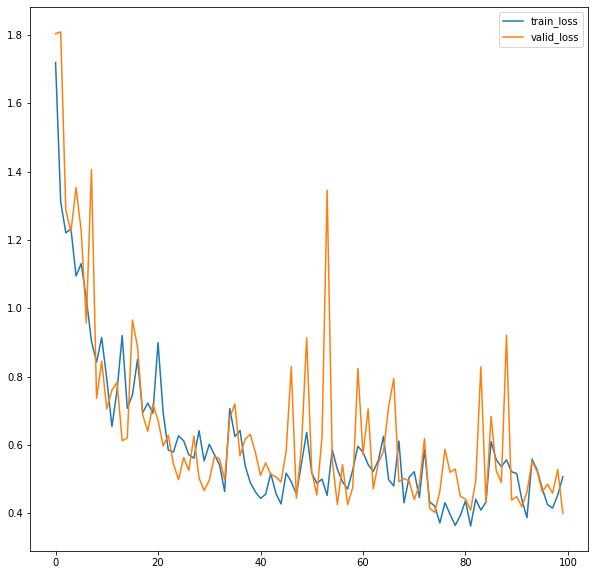

In [28]:
fig = plt.figure(figsize=(10,10))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train_loss','valid_loss'])

In [29]:
fig.savefig('losses.png')

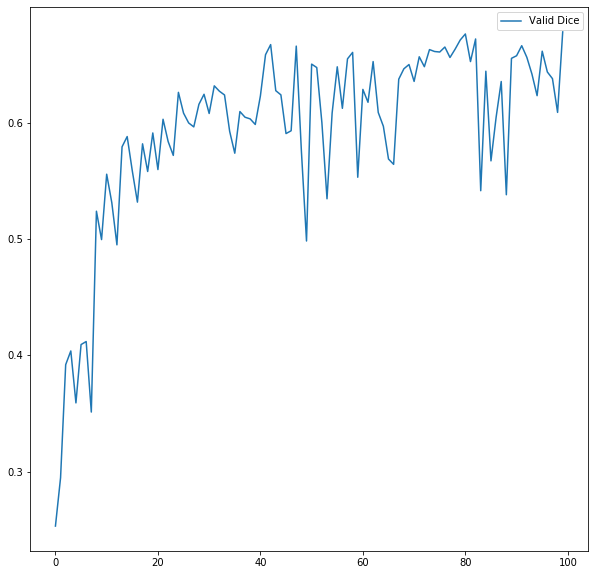

In [31]:
plt.close('all')
fig = plt.figure(figsize=(10,10))
plt.plot(dices)
plt.legend(['Valid Dice'])

In [32]:
fig.savefig('valid_dice.png')

# Test

In [7]:
model.load_state_dict(torch.load('best_dice_camvid.pkl'))

<All keys matched successfully>

In [9]:
model.eval()
model.cuda()
d=0
for i,batch in enumerate(tqdm(test_dl)):
    ypred = model(batch['im'].cuda())
    yb = batch['mask'].cuda()
    d += dice(ypred.detach(),yb).item()
print(d/(i+1))


0.5625043829282125


# Visualize some results

In [9]:
model.cuda()
model.eval()
op = nn.LogSoftmax(dim=1)(model(test_data[10]['im'].unsqueeze(0).cuda()))
op = op.argmax(dim=1)

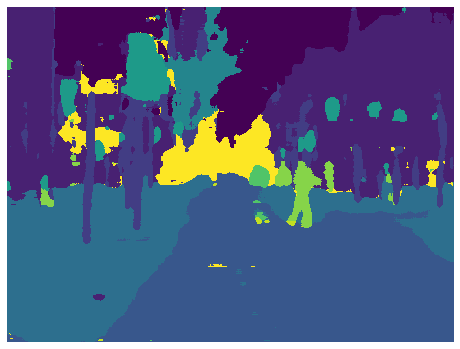

In [10]:
from fastai.vision import Image as Fimage
Fimage(op.detach()).show(figsize=(8,8))

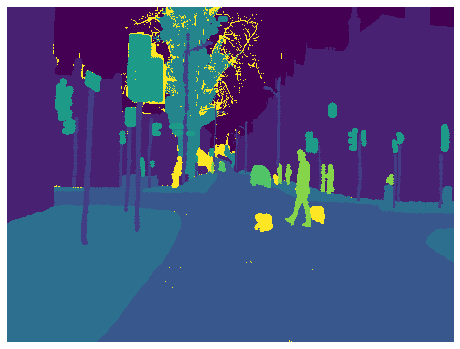

In [11]:
Fimage(test_data[10]['mask'].unsqueeze(0)).show(figsize=(8,8))

In [18]:
test_data.files.index('../SegNet-Tutorial/CamVid/test/Seq05VD_f04050.png')

156